### Speed Challenge - Naveen

In [1]:
import numpy as np
import os
import pandas as pd
import sys
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
%matplotlib inline

In [2]:
path = os.path.curdir
img_path = os.path.join(path, 'data/RGBflow/')
speeds = pd.read_table(os.path.join(path, 'data/') + 'train.txt', delimiter='\n', header=None, names=['speed'])
print(speeds.head())
print('Total images: ' + str(len(speeds)))

       speed
0  28.105569
1  28.105569
2  28.106527
3  28.130404
4  28.109243
Total images: 20400


RGB flow images, each image is dense optical flow from its previous image


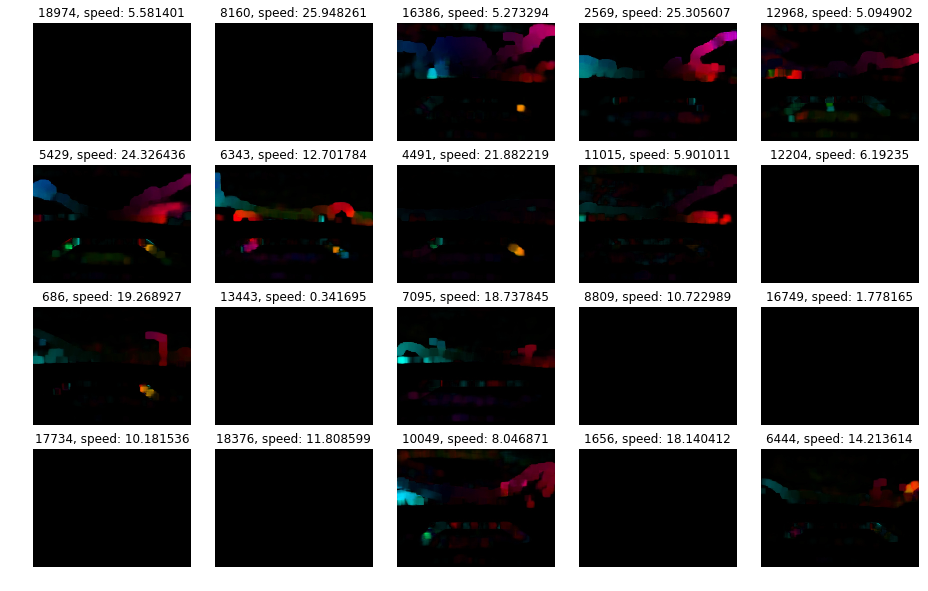

In [3]:
# 20 Random indices for images in RGBflow folder
random_images = [np.random.randint(len(speeds)) for i in range(20)]

print("RGB flow images, each image is dense optical flow from its previous image")
plt.figure(figsize=(16, 10))
gs1 = gridspec.GridSpec(4, 5)
gs1.update(wspace = 0.1, hspace = 0.2)
for idx, image in enumerate(random_images): 
    ax1 = plt.subplot(gs1[idx])
    ax1.axis('off')
    plt.title(str(image) + ', speed: ' + str(speeds.loc[image, 'speed']))
    img = cv2.imread(img_path + 'frame' + str(image) + '.jpg')
    plt.imshow(img)
plt.show()

In [4]:
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Activation, Dropout, Flatten, Dense, Lambda
from keras.layers import ELU
from keras.optimizers import Adam
import keras.backend.tensorflow_backend as KTF
import h5py

Using TensorFlow backend.


In [7]:
images = [i for i in range(len(os.listdir(img_path)))]
split = 0.987
train, valid = images[:int(len(images) * split)], images[int(len(images) * split):]
len(train), len(valid)

(20132, 266)

In [8]:
# generators for train and validation data
img_path = os.path.join(path, 'data/resized/')

def training_data(data, batch_size = 32):
    image_batch = np.zeros((batch_size, 120, 160, 3))
    label_batch = np.zeros((batch_size))
    while True:
        for i in range(batch_size):
            image_batch[i] = mpimg.imread(img_path + 'frame' + str(i) + '.jpg') / 255
            label_batch[i] = speeds.iloc[i]
        yield image_batch, label_batch   

def validation_data(data):
    image_batch = np.zeros((len(data), 120, 160, 3))
    label_batch = np.zeros((len(data)))
    while True:
        for i in range(len(data)):
            image_batch[i] = mpimg.imread(img_path + 'frame' + str(i) + '.jpg') / 255
            label_batch[i] = speeds.iloc[i]
        yield image_batch, label_batch

In [9]:
N_img_height = 120
N_img_width = 160
N_img_channels = 3
def model():
    inputShape = (N_img_height, N_img_width, N_img_channels)

    model = Sequential()
    # normalization    
    # perform custom normalization before lambda layer in network
    model.add(Lambda(lambda x: x, input_shape = inputShape))

    model.add(Convolution2D(24, (5, 5), 
                            strides=(2,2), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv1'))
    
    
    model.add(ELU())    
    model.add(Convolution2D(36, (5, 5), 
                            strides=(2,2), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv2'))
    
    model.add(ELU())    
    model.add(Convolution2D(48, (5, 5), 
                            strides=(2,2), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv3'))
    model.add(ELU())
    model.add(Dropout(0.5))
    model.add(Convolution2D(64, (3, 3), 
                            strides = (1,1), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv4'))
    
    model.add(ELU())              
    model.add(Convolution2D(64, (3, 3), 
                            strides= (1,1), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv5'))
              
              
    model.add(Flatten(name = 'flatten'))
    model.add(ELU())
    model.add(Dense(100, kernel_initializer = 'he_normal', name = 'fc1'))
    model.add(ELU())
    model.add(Dense(50, kernel_initializer = 'he_normal', name = 'fc2'))
    model.add(ELU())
    model.add(Dense(10, kernel_initializer = 'he_normal', name = 'fc3'))
    model.add(ELU())
    
    # do not put activation at the end because we want to extract output, not a class identifier
    model.add(Dense(1, name = 'output', kernel_initializer = 'he_normal'))
    
    adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(optimizer = adam, loss = 'mse')

    return model

In [10]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
filepath = os.path.join(path, 'data/') + 'model-weights-Vtest3.h5'
earlyStopping = EarlyStopping(monitor='val_loss', 
                              patience=1, 
                              verbose=1, 
                              min_delta = 0.23,
                              mode='min',)
modelCheckpoint = ModelCheckpoint(filepath, 
                                  monitor = 'val_loss', 
                                  save_best_only = True, 
                                  mode = 'min', 
                                  verbose = 1,
                                 save_weights_only = True)
callbacks_list = [modelCheckpoint, earlyStopping]


In [11]:
history = model().fit_generator(
        training_data(train, 16), 
        steps_per_epoch = 400, 
        epochs = 60,
        callbacks = callbacks_list,
        verbose = 1,
        validation_data = validation_data(valid),
        validation_steps = len(valid))

print(history)

Epoch 1/60
400/400 [==============================] - 437s - loss: 43.1714 - val_loss: 20.2724
Epoch 2/60
400/400 [==============================] - 432s - loss: 0.1246 - val_loss: 18.4739
Epoch 3/60
400/400 [==============================] - 432s - loss: 0.0949 - val_loss: 18.6019
Epoch 4/60
400/400 [==============================] - 437s - loss: 0.0708 - val_loss: 18.4167
Epoch 00003: early stopping


dict_keys(['val_loss', 'loss'])


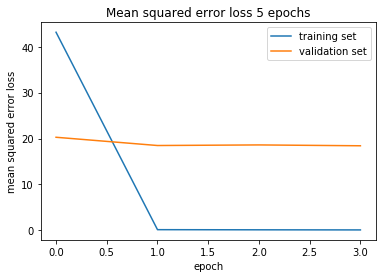

In [12]:
print(history.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Mean squared error loss 5 epochs')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.savefig(os.path.join(path, 'data/loss.png'))
plt.show()

In [13]:
# generate test data
img_path = os.path.join(path, 'data/resizedtest/')

def test_data(data, batch_size = 32):
    image_batch = np.zeros((batch_size, 120, 160, 3))
    while True:
        for i in range(batch_size):
            image_batch[i] = mpimg.imread(img_path + 'frame' + str(i) + '.jpg') / 255
        yield image_batch

In [14]:
m = model()
m.load_weights(os.path.join(path, 'data/') + 'model-weights-Vtest3.h5')
test_images = [i for i in range(len(os.listdir(img_path)))]

In [15]:
test_predict = m.predict_generator(test_data(test_images, 16), 
                                   steps=674, 
                                   verbose=1)

674/674 [==============================] - 55s    


In [26]:
np.max(test_predict)

28.516033